# Example - M100 Fluke Training 
> **On the AM0.1-FLUKE dataset**   
> Train dataset on a google Colab instance  
> Run training of model AM0.1 on fluke dataset, from Claire, markupup by Stacey  
> This dataset has  has 354 800 pixel row images images at ~ rpi 1/2 resolution  
> These are cropped into  ~ 522 images  200 x 200 pixel size  
**[Run this file online in Colab](https://colab.research.google.com/github/johnnewto/cellsegment/blob/master/nbs/21_training_M100_fluke_colab.ipynb)**

In [0]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#hide
def in_colab():
    "Check if the code is running in Google Colaboratory"
    try:
        from google import colab
        return True
    except: return False
IN_COLAB = in_colab()


In [3]:
%%bash

ls -a

.
..
.config
sample_data


In [4]:
%%bash
rm -rf /content/*
rm -rf /content/.config
rm -rf /content/.git*

git clone https://github.com/drmcg/cellsegment.git .



Cloning into '.'...


In [5]:
%%bash

git checkout drmcg-patch-1

Branch 'drmcg-patch-1' set up to track remote branch 'drmcg-patch-1' from 'origin'.


Switched to a new branch 'drmcg-patch-1'


In [6]:
import os
#hide
if IN_COLAB:
    print('Cloning the cellsegment library')
    os.system('mkdir -p /root/.torch/models')
    os.system('mkdir -p /root/.fastai/data')
    os.system('ln -s /root/.torch/models /content')
    os.system('ln -s /root/.fastai/data /content')
    #os.system('rm -rf /content/sample_data/')


Cloning the cellsegment library


## Setup

### Imports

In [0]:
from cellsegment.core import *
from cellsegment.dataprep_utils import *
from cellsegment.inference_utils import *
from cellsegment.set_directories import *
import pandas
from fastai import *
from fastai.vision import *

### Define directories

In [8]:
dirs = Dirs('data') if IN_COLAB else Dirs('../testdata/')
print(dirs)


None
  basepath        :  data                 
  crop            :  data/Crop-200        
  cropLabel       :  data/Crop-200/Label  
  cropTest        :  data/Crop-200/Test   
  cropTrain       :  data/Crop-200/Train  
  cropValidTxtFile:  data/Crop-200/valid.txt 
  label           :  data/Fullsize/Label  
  model           :  data/models/         
  originImages    :  data/Original        
  sizeCsvFile     :  data/file_size.csv   
  test            :  data/Fullsize/Test   
  train           :  data/Fullsize/Train  
  validTxtFile    :  data/Fullsize/valid.txt 



In [0]:
#! pip install fastai==1.0.57 

In [10]:
! pip freeze | grep 'fastai\|torch*'    
    
# the following liberies are known to work
# fastai==1.0.57
# torch==1.1.0
# torchvision==0.3.0

fastai==1.0.60
torch==1.4.0
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.5.0


In [11]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    data_dir = "/content/drive/My Drive/Colab Notebooks/Tection/data"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Dataprep - optional, if not alread done

### Load the Training Images

In [12]:
%%bash
[[ ! -e /tools/google-cloud-sdk ]] &&  exit 

    export fileid=1SEW0Kf1CI4e4-up4TGsDqwDwVk_QZEUf
    export filename=Fluke-Train-2019-12-01.zip

    ## CURL ##
    curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid \
         | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    curl -L -b cookies.txt -o $filename \
         'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
    rm -f confirm.txt cookies.txt
    
    unzip -u -q $filename -d data


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3247    0  3247    0     0  12936      0 --:--:-- --:--:-- --:--:-- 12936
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   3067      0 --:--:-- --:--:-- --:--:--  3067
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 62.3M    0 62.3M    0     0  39.0M      0 --:--:--  0:00:01 --:--:--  218M


In [0]:
file_csv = dirs.basepath+'/file_data.csv'
fnames = sorted(get_image_files(dirs.train))
fnames = [fn.name for fn in fnames]
df = pandas.DataFrame(fnames)
df.columns = ['Name']
df.to_csv(file_csv, index=False)

In [14]:
! rm -r /content/data/Crop-200

rm: cannot remove '/content/data/Crop-200': No such file or directory


### Shuffle and Split file list  into train, valid catagories

In [0]:
shuffle_csv(file_csv,random_state=23)
split_filenames(file_csv, num_train=0.7, num_val=0.15)

### Crop the image files based on json file centers

In [16]:

fill = misslist, croplist= crop_img_dir(dirs.basepath+'/file_data.csv', 
                                              dirs.train, dirs.train, dirs.crop, 
                                              number_files='all', DEBUG=False)
print(f'Num Missed: {len(misslist)}, Num Cropped: {len(croplist)}')

354 files to process in data/Fullsize/Train

Missed 0 and  Cropped 526 files in data/Crop-200
Num Missed: 0, Num Cropped: 526


### Make crop file list and valid file list, save as csv and txt files

In [17]:
crop_df = pd.DataFrame(croplist)
crop_df = crop_df[['Name','Label', 'Op']]

# relabel with text
crop_df.loc[crop_df.Label == '40','Label'] = 'Fluke-Rumen'
crop_df.loc[crop_df.Label == '11','Label'] = 'Fluke-Liver'
crop_df.to_csv(dirs.crop+'/crop_df.csv', index=False)

crop_df.tail(10)

Name        Label    Op
516   236571 - 3-0.jpg  Fluke-Rumen  Test
517  236568 - 46-0.jpg  Fluke-Liver  Test
518  235444 - 11-0.jpg  Fluke-Liver  Test
519  235444 - 11-1.jpg  Fluke-Liver  Test
520   235444 - 2-0.jpg  Fluke-Liver  Test
521   235444 - 2-1.jpg  Fluke-Liver  Test
522   236568 - 4-0.jpg  Fluke-Liver  Test
523   236568 - 4-1.jpg  Fluke-Liver  Test
524  235445 - 15-0.jpg  Fluke-Liver  Test
525  235445 - 15-1.jpg  Fluke-Liver  Test

In [18]:
valid_df = crop_df[crop_df.Op=='Valid'].loc[:,'Name']
valid_df.to_csv(dirs.crop+'/valid.txt', index=False, header=True)
valid_df.head(10)


368    236569 - 29-0.jpg
369    235444 - 14-0.jpg
370    236568 - 78-0.jpg
371    235444 - 39-0.jpg
372    236568 - 61-0.jpg
373     236567 - 5-0.jpg
374     236567 - 5-1.jpg
375     236567 - 5-2.jpg
376    236568 - 80-0.jpg
377     236571 - 1-0.jpg
Name: Name, dtype: object

### Crop the label files based on json file centers

In [19]:
labmisslist, labcroplist = crop_img_dir(file_csv, dirs.train, dirs.label, dirs.crop, number_files='all')
print(f'Num Missed: {len(labmisslist)}, Num Cropped: {len(labcroplist)}')


354 files to process in data/Fullsize/Label

Missed 0 and  Cropped 526 files in data/Crop-200
Num Missed: 0, Num Cropped: 526


In [20]:
test_df = crop_df[crop_df.Op == 'Test'] 
test_df.to_csv(dirs.crop+'/test_df.csv', index=False)
test_df.tail(10)

Name        Label    Op
516   236571 - 3-0.jpg  Fluke-Rumen  Test
517  236568 - 46-0.jpg  Fluke-Liver  Test
518  235444 - 11-0.jpg  Fluke-Liver  Test
519  235444 - 11-1.jpg  Fluke-Liver  Test
520   235444 - 2-0.jpg  Fluke-Liver  Test
521   235444 - 2-1.jpg  Fluke-Liver  Test
522   236568 - 4-0.jpg  Fluke-Liver  Test
523   236568 - 4-1.jpg  Fluke-Liver  Test
524  235445 - 15-0.jpg  Fluke-Liver  Test
525  235445 - 15-1.jpg  Fluke-Liver  Test

### Remove  pallet info from label images as it seems to mess up the dataloader

In [21]:
fnames =  get_image_files(Path(dirs.crop)/'Label')
# fnames = fnames[:3]
for fn in fnames:
    img = np.asarray(PIL.Image.open(fn))
    PIL.Image.fromarray(img.astype(np.uint8)).save(fn, quality=90)
print(f'Label files: {len(fnames)} resaved')

Label files: 526 resaved


## Training Section

### Create DataBunch

In [22]:
path_img = dirs.cropTrain
path_lbl = dirs.cropLabel

codes = np.array(['background', '1', '2', '3']);codes

get_label_fn = lambda x: f'{path_lbl}/{x.stem}.png'

src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_label_fn, classes=codes, convert_mode='RGB'))

tfms = get_transforms(flip_vert=True, max_rotate=10, max_zoom=1.1, max_warp=0.2)
if IN_COLAB:
    bs = 60
else:
    bs = 20  
data = (src.transform(tfms, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
print("bs = ", bs)
print(data)

bs =  60
ImageDataBunch;

Train: LabelList (368 items)
x: SegmentationItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: SegmentationLabelList
ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200)
Path: data/Crop-200/Train;

Valid: LabelList (75 items)
x: SegmentationItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: SegmentationLabelList
ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200)
Path: data/Crop-200/Train;

Test: None


### Show example images


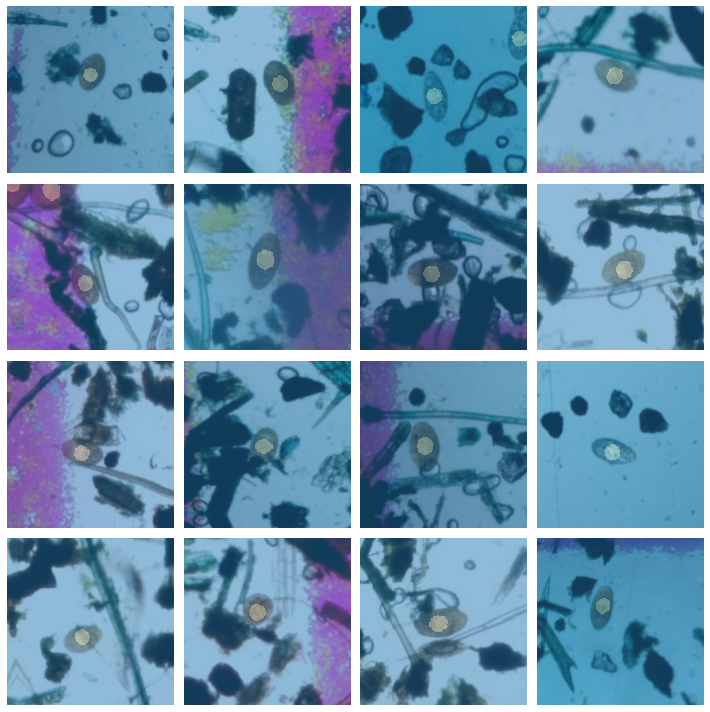

In [23]:
data.show_batch(4, ds_type=DatasetType.Train, figsize=(10,10))

### Learner

In [24]:
# import pdb
# pdb.set_trace()
def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
  
metrics=[acc_metric1, acc_metric2]


wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


### find best learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


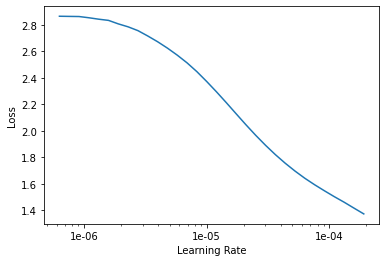

In [25]:
if torch.cuda.is_available():
    learn.lr_find()
    learn.recorder.plot()

### Train Body  for 20 epochs with adam

In [26]:
lr = 3e-3
learn.fit_one_cycle(20, slice(lr))

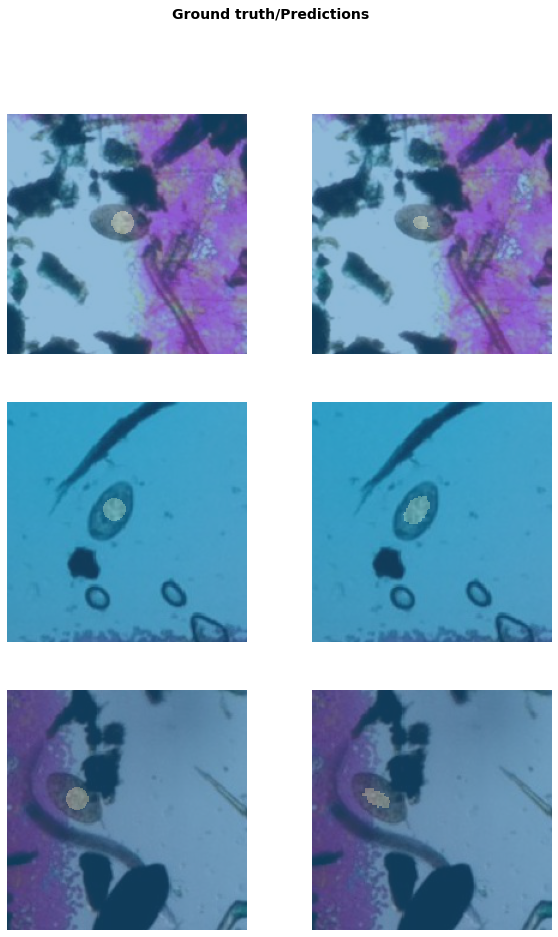

In [27]:
learn.show_results(rows=3, imgsize=5)

In [0]:

learn.save('stage1')

In [0]:
os.rename(learn.data.path/'models/stage1.pth', 'stage1.pth')
! cp 'stage1.pth' 'drive/My Drive/Colab Notebooks/Techion/data/models'
! cp 'stage1.pth' 'data/Crop-200/Train/models'

In [30]:
learn.load('stage1')

Learner(data=ImageDataBunch;

Train: LabelList (368 items)
x: SegmentationItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: SegmentationLabelList
ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200)
Path: data/Crop-200/Train;

Valid: LabelList (75 items)
x: SegmentationItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: SegmentationLabelList
ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200)
Path: data/Crop-200/Train;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

### Unfreeze and train body for another 10 cycles

In [0]:
learn.unfreeze()

In [32]:
learn.fit_one_cycle(10, slice(lr/10))

In [0]:
defaults.device = torch.device('cpu')
learn.export('export.pkl')
os.rename(learn.data.path/'export.pkl', 'export-fluke-2020-04-06.pkl')
! cp 'export-fluke-2020-04-06.pkl' 'drive/My Drive/Colab Notebooks/Techion/data/Fluke'
! cp 'export-fluke-2020-04-06.pkl' 'export-fluke.pkl'


In [0]:
learn.save('stage2')

In [0]:
os.rename(learn.data.path/'models/stage2.pth', 'stage2.pth')
! cp 'stage2.pth' 'drive/My Drive/Colab Notebooks/Techion/data/Fluke'
! cp 'stage2.pth' 'data/Crop-200/Train/models'

# Work in Progress - Inference Section

## Load exported Model

In [55]:
#defaults.device = 'cpu'
#defaults.device = 'cuda'

if not torch.cuda.is_available():
    # switch to CPU if not GPU
    print("No GPU using CPU")
    defaults.device = torch.device('cpu')
else:
    print("GPU found")
    defaults.device = torch.device('cuda')


def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
    
learn = load_learner('', 'export-fluke.pkl')

learn.model.float()

GPU found


DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [0]:
#learn.show_results(rows=5, figsize=(10,20), ds_type=DatasetType.Valid)

In [0]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def show_img(im, figsize=None, ax=None, alpha=None, label=None, title=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if label: ax.legend()
    if title: ax.set_title(title)
    return ax

## Run model inference on all of the 78 Test tiles

In [39]:
path = Path('data/Crop-200')
path_img = path/'Train'
path_lbl = path/'Label'
path_tst = path/'Test'

fnames =  get_image_files(path_tst)

print (f'Number of test tiles {len(fnames)}')

Number of test tiles 83


In [0]:
# Plot test images with auto markup labels
def run_inference(fnames, offset=0):
    fig, axes = plt.subplots(4, 5, figsize=(16, 12))
    for i, ax in enumerate(axes.flat):
        if i+offset >= len(fnames): break
        img = open_image(fnames[i+offset])
        pc,pi,o = learn.predict(img)
        show_image(img, ax=ax)
        show_image(pc, ax=ax,  cmap='tab20', alpha=0.5)
        draw_text(ax, (0, 0), fnames[i+offset].stem, color='red')

    plt.tight_layout()

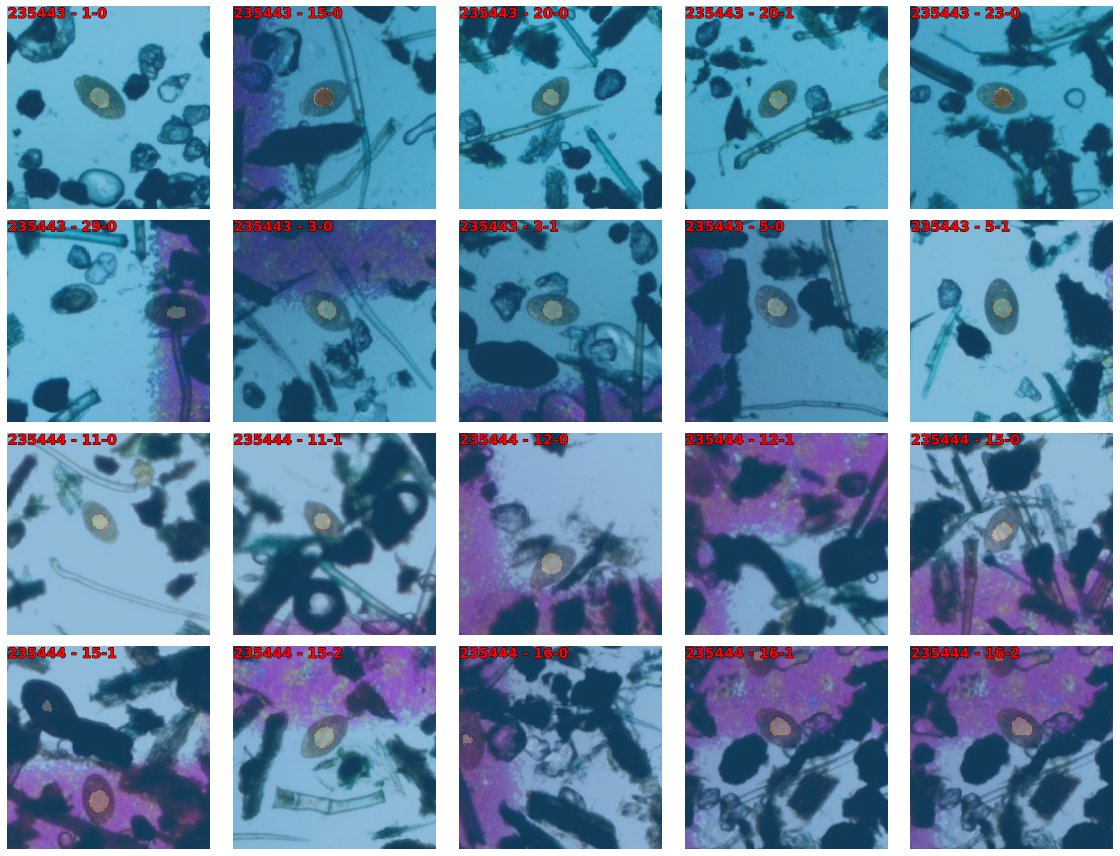

In [41]:
fnames =  sorted(get_image_files(path/'Test'))
run_inference(fnames, offset=0)

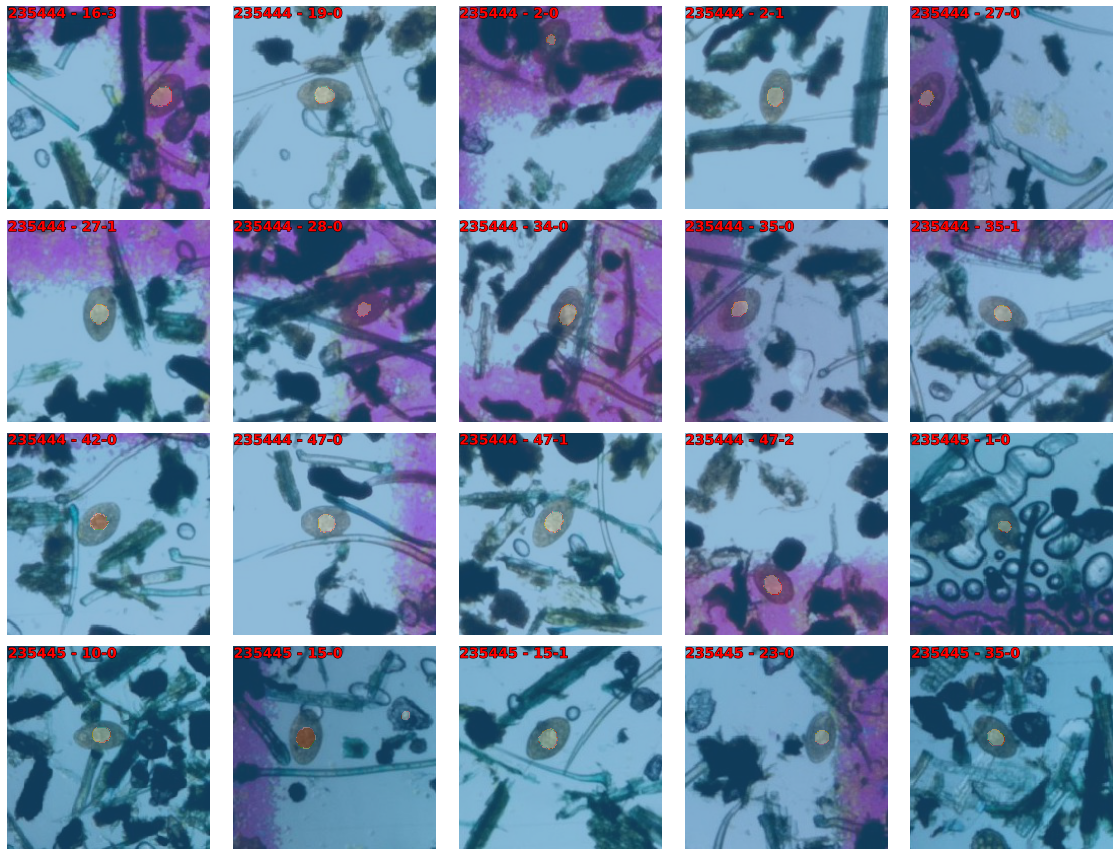

In [42]:
run_inference(fnames, offset=20)

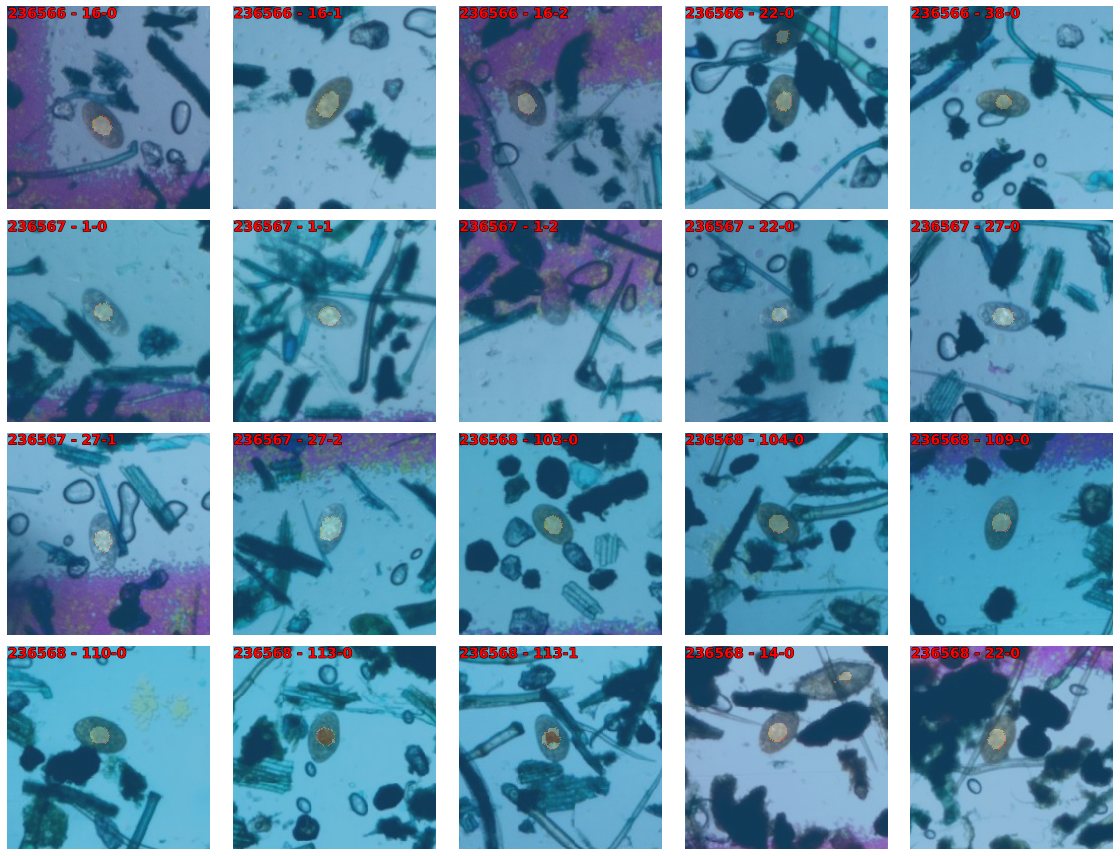

In [43]:
run_inference(fnames, offset=40)

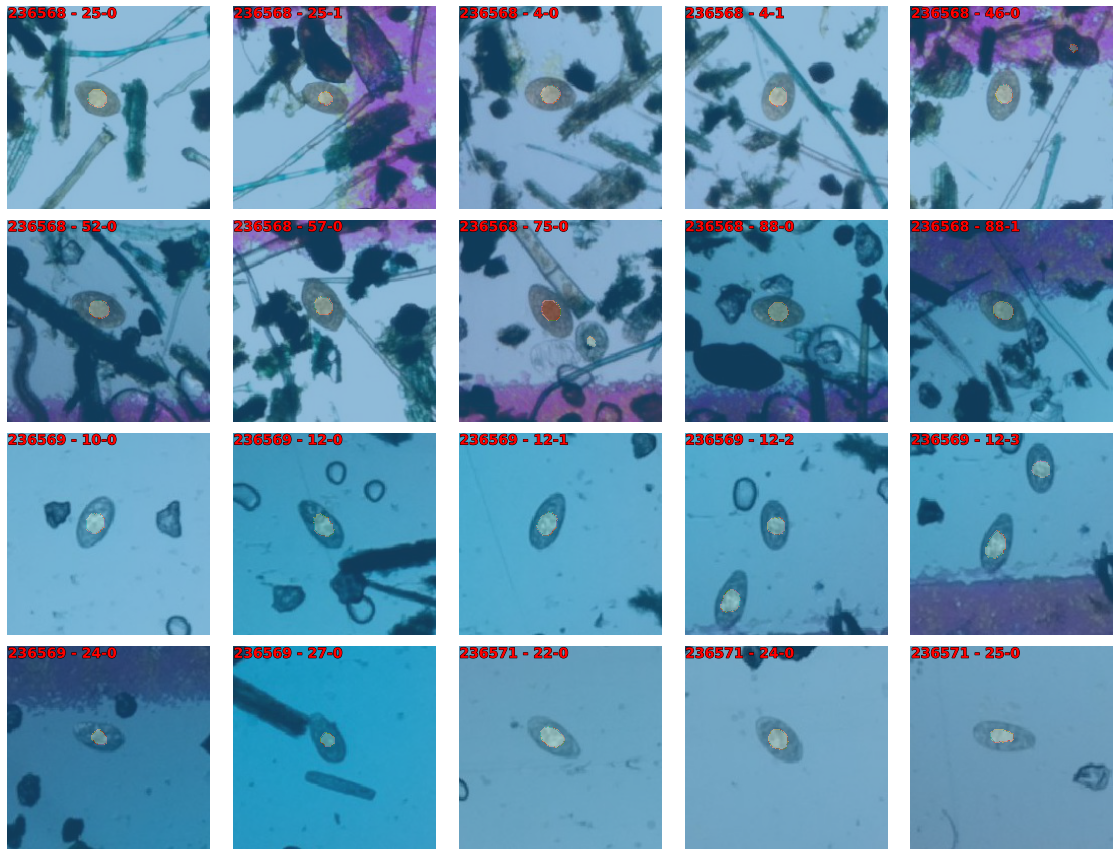

In [44]:
run_inference(fnames, offset=60)

In [45]:
fnames =  sorted(get_image_files(path/'Test'))

# preds= iu.run_inferences(learn, fnames, start=60)
preds= run_inferences(learn, fnames, number_files='all')
len(preds)

83

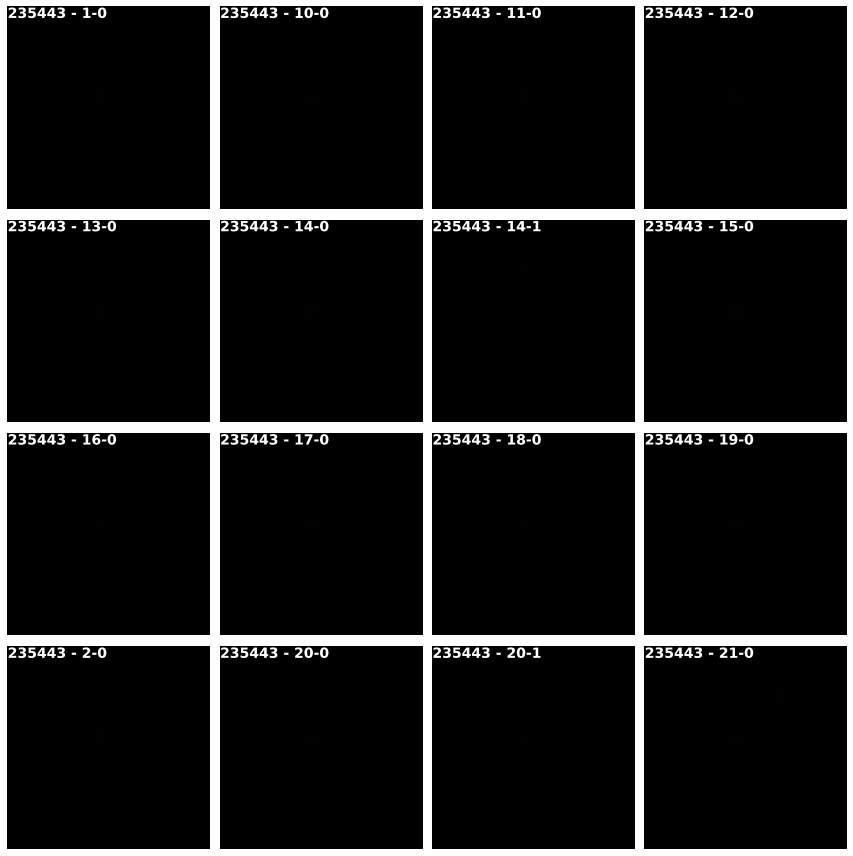

In [46]:
# Plot images and labels
fnames =  sorted(get_image_files(path/'Label'))

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    img = open_image(fnames[i])
    # pc,pi,o = learn.predict(img)
    ax = show_image(img, ax=ax)
    draw_text(ax, (0, 0), fnames[i].stem)

plt.tight_layout()

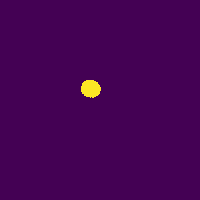

In [47]:
# for fn in fnames:
fnames =  sorted(get_image_files(path/'Test'))
fn = fnames[65]
img = open_image(fn)
pc,pi,o = learn.predict(img)
#     PIL.Image.fromarray(img.astype(np.uint8)).save(fn, quality=90)
# print(f'Label files: {len(fnames)} resaved')

pc

In [48]:
o.shape

torch.Size([4, 200, 200])

In [49]:
o

tensor([[[9.9763e-01, 9.9961e-01, 9.9984e-01,  ..., 1.0000e+00,
          9.9998e-01, 9.9998e-01],
         [9.9961e-01, 9.9992e-01, 9.9995e-01,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [9.9993e-01, 9.9999e-01, 9.9999e-01,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         ...,
         [9.9873e-01, 9.9922e-01, 9.9961e-01,  ..., 9.9893e-01,
          9.9871e-01, 9.9891e-01],
         [9.9088e-01, 9.9289e-01, 9.9582e-01,  ..., 9.9652e-01,
          9.9420e-01, 9.9546e-01],
         [9.7996e-01, 9.8686e-01, 9.9474e-01,  ..., 9.9567e-01,
          9.9015e-01, 9.8442e-01]],

        [[8.8897e-04, 6.8308e-05, 1.5352e-05,  ..., 1.4875e-07,
          1.3494e-06, 3.8800e-06],
         [6.9392e-05, 2.3593e-06, 4.5227e-07,  ..., 2.9150e-09,
          8.6568e-08, 7.6910e-07],
         [6.9798e-06, 1.8458e-07, 9.0898e-09,  ..., 1.0466e-10,
          1.3421e-09, 4.0432e-08],
         ...,
         [1.1354e-03, 7.2009e-04, 3.5560e-04,  ..., 9.6874e-04,
          1.202

In [50]:
# 236569 - 20-0
fnames =  sorted(get_image_files(path/'Test'))
for i , fn in enumerate(fnames):
    print(i, fn)


0 data/Crop-200/Test/235443 - 1-0.jpg
1 data/Crop-200/Test/235443 - 15-0.jpg
2 data/Crop-200/Test/235443 - 20-0.jpg
3 data/Crop-200/Test/235443 - 20-1.jpg
4 data/Crop-200/Test/235443 - 23-0.jpg
5 data/Crop-200/Test/235443 - 29-0.jpg
6 data/Crop-200/Test/235443 - 3-0.jpg
7 data/Crop-200/Test/235443 - 3-1.jpg
8 data/Crop-200/Test/235443 - 5-0.jpg
9 data/Crop-200/Test/235443 - 5-1.jpg
10 data/Crop-200/Test/235444 - 11-0.jpg
11 data/Crop-200/Test/235444 - 11-1.jpg
12 data/Crop-200/Test/235444 - 12-0.jpg
13 data/Crop-200/Test/235444 - 12-1.jpg
14 data/Crop-200/Test/235444 - 15-0.jpg
15 data/Crop-200/Test/235444 - 15-1.jpg
16 data/Crop-200/Test/235444 - 15-2.jpg
17 data/Crop-200/Test/235444 - 16-0.jpg
18 data/Crop-200/Test/235444 - 16-1.jpg
19 data/Crop-200/Test/235444 - 16-2.jpg
20 data/Crop-200/Test/235444 - 16-3.jpg
21 data/Crop-200/Test/235444 - 19-0.jpg
22 data/Crop-200/Test/235444 - 2-0.jpg
23 data/Crop-200/Test/235444 - 2-1.jpg
24 data/Crop-200/Test/235444 - 27-0.jpg
25 data/Crop-200/

In [51]:
fnames[65]

PosixPath('data/Crop-200/Test/236568 - 52-0.jpg')

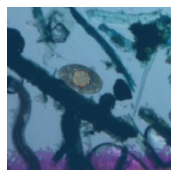

In [52]:
ax = show_image(img)
ax = show_image(pc,ax=ax, cmap='tab20', alpha=0.4)
# im = image2np(pc.cpu())

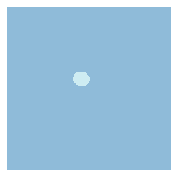

In [53]:
pc.show()

In [54]:
o

tensor([[[9.9763e-01, 9.9961e-01, 9.9984e-01,  ..., 1.0000e+00,
          9.9998e-01, 9.9998e-01],
         [9.9961e-01, 9.9992e-01, 9.9995e-01,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [9.9993e-01, 9.9999e-01, 9.9999e-01,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         ...,
         [9.9873e-01, 9.9922e-01, 9.9961e-01,  ..., 9.9893e-01,
          9.9871e-01, 9.9891e-01],
         [9.9088e-01, 9.9289e-01, 9.9582e-01,  ..., 9.9652e-01,
          9.9420e-01, 9.9546e-01],
         [9.7996e-01, 9.8686e-01, 9.9474e-01,  ..., 9.9567e-01,
          9.9015e-01, 9.8442e-01]],

        [[8.8897e-04, 6.8308e-05, 1.5352e-05,  ..., 1.4875e-07,
          1.3494e-06, 3.8800e-06],
         [6.9392e-05, 2.3593e-06, 4.5227e-07,  ..., 2.9150e-09,
          8.6568e-08, 7.6910e-07],
         [6.9798e-06, 1.8458e-07, 9.0898e-09,  ..., 1.0466e-10,
          1.3421e-09, 4.0432e-08],
         ...,
         [1.1354e-03, 7.2009e-04, 3.5560e-04,  ..., 9.6874e-04,
          1.202